In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

In [3]:
# Force a garbage collection process
gc.collect()

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import  roc_auc_score, accuracy_score, classification_report

In [31]:
df = pd.read_csv("data_pre.csv")

In [32]:
df.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDate,mismatched_country,mismatched_cvv,time_diff
0,100737756,250,250.00,2016-01-07 09:37:09,1.86,1st Sandwitch Bar #396252,US,US,05,01,...,4317,PURCHASE,0.00,True,False,False,2016-01-07,True,True,<Unknown>
1,100737756,250,248.14,2016-01-08 16:20:51,193.25,Downtown Pub,US,US,02,01,...,4317,PURCHASE,1.86,True,False,False,2016-01-08,True,True,1 days 06:43:42
2,100737756,250,54.89,2016-01-10 21:02:12,650.62,Franks Pub #87366,US,US,09,01,...,4317,PURCHASE,195.11,True,False,False,2016-01-10,True,True,2 days 04:41:21
3,100737756,250,-319.58,2016-01-12 17:46:25,0.00,Downtown Sandwitch Bar,US,US,02,01,...,4317,ADDRESS_VERIFICATION,569.58,False,False,False,2016-01-12,True,True,1 days 20:44:13
4,100737756,250,159.70,2016-01-13 21:29:12,104.11,Franks Pub #87366,US,US,05,01,...,4317,PURCHASE,90.30,True,False,False,2016-01-13,True,True,1 days 03:42:47


In [33]:
cols_to_exclude = ["cardCVV", "enteredCVV", "currentExpDate", "accountOpenDate"]
df.drop(cols_to_exclude, axis=1, inplace=True)

In [7]:
features = [
    'customerId',
    'creditLimit',
    'availableMoney',
    'transactionDateTime',
    'transactionAmount',
    'merchantName',
    'acqCountry',
    'merchantCountryCode',
    'posEntryMode',
    'posConditionCode',
    'merchantCategoryCode',
    'dateOfLastAddressChange',
    'cardLast4Digits',
    'transactionType',
    'currentBalance',
    'cardPresent',
    'expirationDateKeyInMatch',
    'transactionDate',
    'mismatched_country',
    'mismatched_cvv',
    'time_diff'
]

cat_features = [
    'customerId',
    'creditLimit',
    'merchantName',
    'acqCountry',
    'merchantCountryCode',
    'posEntryMode',
    'posConditionCode',
    'merchantCategoryCode',
    'cardLast4Digits',
    'transactionType',
    'cardPresent',
    'expirationDateKeyInMatch',
    'mismatched_country',
    'mismatched_cvv',
]


In [8]:
time_columns = ['transactionDateTime', 'dateOfLastAddressChange', 'transactionDate']

for column in time_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce')
    df[column] = df[column].astype('int64') / 10**9  # Convert to Unix timestamp in seconds

df['time_diff'] = pd.to_timedelta(df['time_diff'], errors='coerce').dt.total_seconds()


In [9]:
df.to_csv("df_for_model.csv", index=False)

In [10]:
# Force a garbage collection process
gc.collect()

571

In [11]:
test_size = int(df.shape[0] * 0.1)
tscv = TimeSeriesSplit(test_size=test_size)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}  size={len(train_index)}")
    print(f"  Test:  index={test_index}  size={len(test_index)}")

Fold 0:
  Train: index=[     0      1      2 ... 393180 393181 393182]  size=393183
  Test:  index=[393183 393184 393185 ... 471816 471817 471818]  size=78636
Fold 1:
  Train: index=[     0      1      2 ... 471816 471817 471818]  size=471819
  Test:  index=[471819 471820 471821 ... 550452 550453 550454]  size=78636
Fold 2:
  Train: index=[     0      1      2 ... 550452 550453 550454]  size=550455
  Test:  index=[550455 550456 550457 ... 629088 629089 629090]  size=78636
Fold 3:
  Train: index=[     0      1      2 ... 629088 629089 629090]  size=629091
  Test:  index=[629091 629092 629093 ... 707724 707725 707726]  size=78636
Fold 4:
  Train: index=[     0      1      2 ... 707724 707725 707726]  size=707727
  Test:  index=[707727 707728 707729 ... 786360 786361 786362]  size=78636


In [12]:
target = 'isFraud'
# Split the data into train (70%), validation (15%), and test (15%) sets
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Separate features and target for training, validation, and testing
X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Initialize the CatBoost Classifier and specify categorical features
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, eval_metric='Accuracy', random_seed=42)

# Train the model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=100)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

0:	learn: 0.9841222	test: 0.9844600	best: 0.9844600 (0)	total: 160ms	remaining: 2m 39s
100:	learn: 0.9870670	test: 0.9875206	best: 0.9875545 (63)	total: 22.2s	remaining: 3m 17s
200:	learn: 0.9871760	test: 0.9875799	best: 0.9876138 (196)	total: 45s	remaining: 2m 58s
300:	learn: 0.9872578	test: 0.9875969	best: 0.9876308 (287)	total: 1m 8s	remaining: 2m 38s
400:	learn: 0.9873068	test: 0.9876732	best: 0.9876816 (384)	total: 1m 30s	remaining: 2m 15s
500:	learn: 0.9873759	test: 0.9876647	best: 0.9876986 (431)	total: 1m 55s	remaining: 1m 55s
600:	learn: 0.9874358	test: 0.9876816	best: 0.9877156 (546)	total: 2m 18s	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9877155501
bestIteration = 546

Shrink model to first 547 iterations.
Test Accuracy: 0.9878682548429486
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    116111
        True       0.93      0.24      0.38      1844

    accuracy                  

Test Accuracy: 0.9878682548429486
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    116111
        True       0.93      0.24      0.38      1844

    accuracy                           0.99    117955
   macro avg       0.96      0.62      0.69    117955
weighted avg       0.99      0.99      0.98    117955

AUC Score: 0.8885677892448304


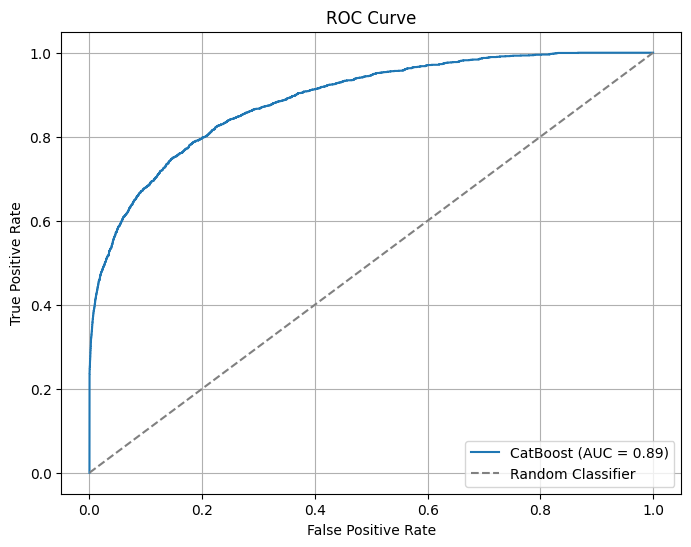

                  Feature Id  Importances
0          transactionAmount    24.314573
1               merchantName    15.892940
2               posEntryMode    15.002017
3       merchantCategoryCode    13.346243
4                 customerId    10.648508
5                cardPresent     8.426391
6            cardLast4Digits     2.014935
7           posConditionCode     1.729444
8    dateOfLastAddressChange     1.199746
9                  time_diff     1.168063
10            currentBalance     1.079941
11       merchantCountryCode     1.076336
12            availableMoney     1.043104
13           transactionDate     0.696507
14               creditLimit     0.693310
15           transactionType     0.559479
16                acqCountry     0.381201
17            mismatched_cvv     0.337208
18       transactionDateTime     0.323233
19        mismatched_country     0.058783
20  expirationDateKeyInMatch     0.008040


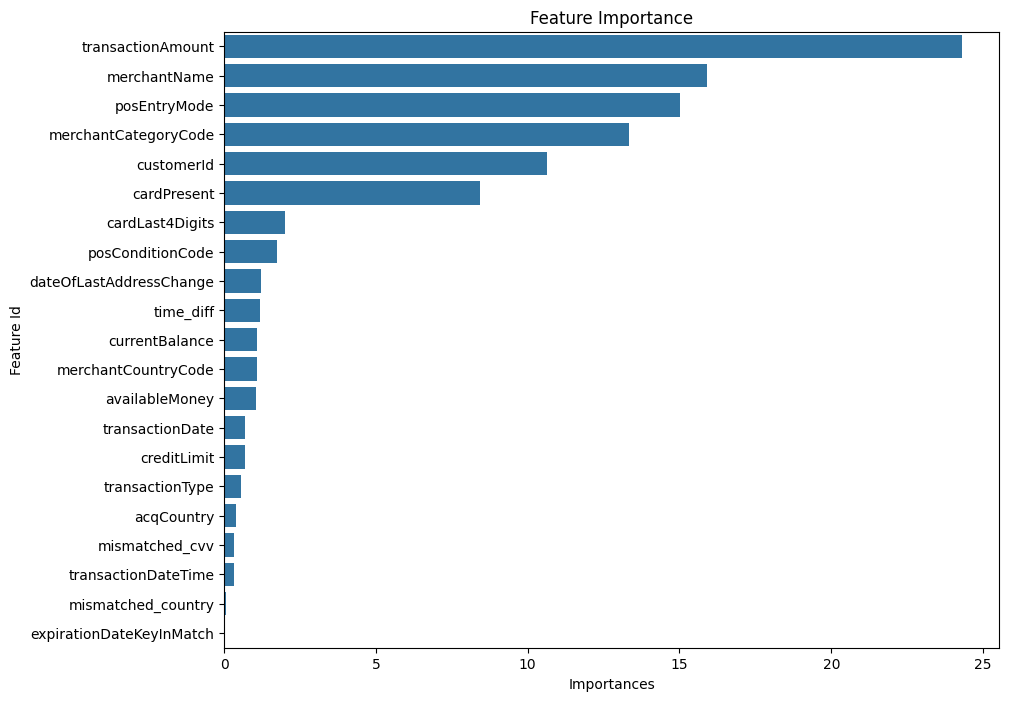

In [14]:
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, accuracy_score
# Assuming model has already been trained and y_test, y_pred, X_test are defined

# 1. Evaluate the model using classification report and accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# 2. Calculate the probabilities for the positive class (fraud)
y_prob = model.predict_proba(X_test)[:, 1]  # Getting the probabilities for the positive class (isFraud = 1)

# 3. Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {roc_auc}")

# 4. Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. Feature Importance
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['Importances'], y=feature_importances['Feature Id'])
plt.title('Feature Importance')
plt.show()

